In [1]:
# Include sslearn folder
import sys
sys.path.append('..')
import pickle as pkl
import numpy as np
from SequenceEncoding import SequenceEncoding
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, weightedtau
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations, permutations

In [2]:
#results_dir = "results/multiview_extrapolation_experiments_trainedwith_1_testedwith_2_trainedwith_1_testedwith_2_avgfp_MultiviewCoReg"
#results_dir = "results/multiview_extrapolation_experiments_trainedwith_1_2_3_4_5_6_7_8_9_10_testedwith_1_2_3_4_5_6_7_8_9_10_avgfp_MultiviewCoReg"
results_dir = "results/multiview_preliminar/multiview_extrapolation_experiments_trainedwith_1_2_3_4_5_6_7_8_9_10_testedwith_1_2_3_4_5_6_7_8_9_10_avgfp_MultiviewCoReg"


In [3]:
encodings = ["One_hot", "One_hot_6_bit", "Binary_5_bit", "Hydrophobicity_matrix",
             "Meiler_parameters", "Acthely_factors", "PAM250", "BLOSUM62",
             "Miyazawa_energies", "Micheletti_potentials", "AESNN3",
             "ANN4D", "ProtVec"]
# Get list of tuples from combinations
#labeled_sizes = [0.1, 0.01, 0.001]
labeled_sizes = [0.2]
comb = list(combinations(encodings, 2))

In [4]:
global_pred_dict = dict()

for enc in encodings:
    global_pred_dict[enc] = dict()
    for labeled_size in labeled_sizes:
        with open(f'{results_dir}/pred_dict_ct_{enc}_{labeled_size}.pickle', 'rb') as f:
            data = pkl.load(f)
            global_pred_dict[enc][labeled_size] = data

for enc1, enc2 in comb:
    global_pred_dict[enc1+"-"+enc2] = dict()

    for labeled_size in labeled_sizes:
        with open(f'{results_dir}/pred_dict_ct_{enc1}_{enc2}_{labeled_size}.pickle', 'rb') as f:
            data = pkl.load(f)
            global_pred_dict[enc1+"-"+enc2][labeled_size] = data

# Create results dataframe
df = pd.DataFrame(columns=['Labeled', 'Train_size', 'View', 'AUC'])
for view, labeled_sizes in global_pred_dict.items():
    for labeled_size, preds_list in labeled_sizes.items():
        for preds in preds_list:
            y_proba = preds["y_proba"]
            y_test = preds["original_y_test"]
            train_size = preds["train_len"]
            mse = mean_squared_error(y_test, y_proba)
            spearman_r = spearmanr(y_test, y_proba)[0]
            weighted_tau = weightedtau(y_test, y_proba)[0]
            df = pd.concat([df, pd.DataFrame({'Labeled': labeled_size, 
                                              'Train_size': train_size, 
                                              'View': view, 
                                              'MSE': mse, 
                                              'Spearman_r': spearman_r,
                                              'Weighted_tau': weighted_tau
                                              }, index=[0])], ignore_index=True)

In [5]:
def get_individual_results(df, metric, encodings):
    # Read times best from pkl for each results folder (each pair of encodings)
    individual_results_dict = dict()

    # Getting mean results from kfold
    for enc1, enc2 in combinations(encodings, 2):
        individual_results_dict[(enc1, enc2)] = dict()
        for labeled_percentage in df['Labeled'].unique():
            # Get a dictionary with the mean of k folds
            if enc1 != enc2:
                individual_results_dict[(enc1, enc2)][labeled_percentage] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == f"{enc1}-{enc2}")][metric].mean()
    
    for enc in encodings:
        individual_results_dict[(enc, enc)] = dict()
        for labeled_percentage in df['Labeled'].unique():
            individual_results_dict[(enc, enc)][labeled_percentage] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == f"{enc}")][metric].mean()

    return individual_results_dict

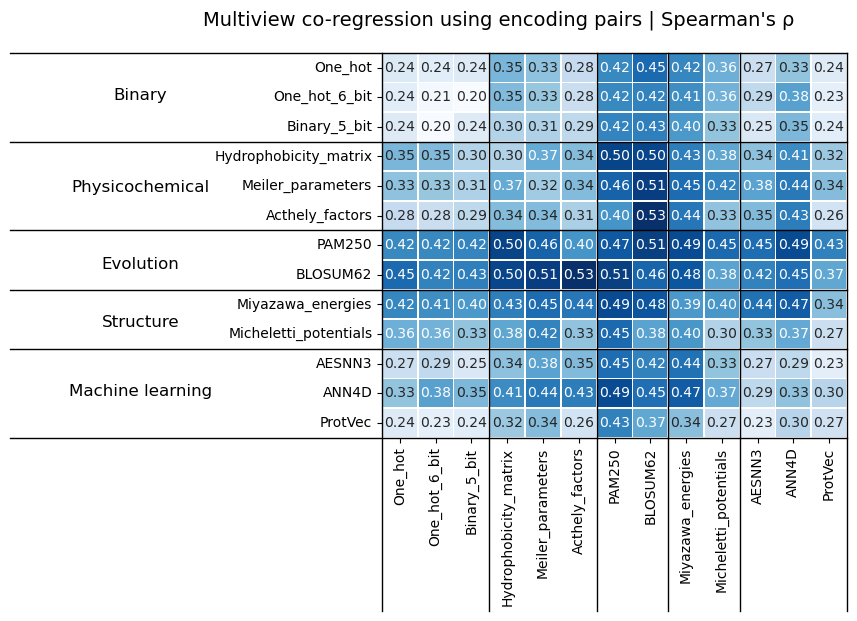

In [71]:
from matplotlib.patches import Patch
for labeled in labeled_sizes:

    metric = 'Spearman_r'

    data = get_individual_results(df, metric, encodings)
    data_items = list(data.items())
    for encoding_pair, results_by_percentage in data_items:
        enc1, enc2 = encoding_pair
        data[enc1, enc2] = results_by_percentage[labeled]
        data[enc2, enc1] = results_by_percentage[labeled]
        

    new_columns_order = ['One_hot', 'One_hot_6_bit', 'Binary_5_bit', # Binary
                        'Hydrophobicity_matrix', 'Meiler_parameters', 'Acthely_factors', # Physicochemical properties
                        'PAM250', 'BLOSUM62', # Evolution-based
                        'Miyazawa_energies', 'Micheletti_potentials', # Structure-based 
                        'AESNN3', 'ANN4D', 'ProtVec']   # Machine learning-based
    groups_dict = {"Binary": ['One_hot', 'One_hot_6_bit', 'Binary_5_bit'],
                    "Physicochemical": ['Hydrophobicity_matrix', 'Meiler_parameters', 'Acthely_factors'],
                    "Evolution": ['PAM250', 'BLOSUM62'],
                    "Structure": ['Miyazawa_energies', 'Micheletti_potentials'],
                    "Machine learning": ['AESNN3', 'ANN4D', 'ProtVec']}

    # Data dict to dataframe
    data = pd.Series(list(data.values()),
                    index=pd.MultiIndex.from_tuples(data.keys()))
    data = data.unstack(level=0)

    # Reorder columns
    data = data[new_columns_order]
    data = data.reindex(new_columns_order)

    # Fig size bigger
    plt.figure(figsize=(6, 5))

    ax1 = sns.heatmap(data, cmap="Blues", annot=True, fmt=".2f", linewidths=.5, cbar=False)

    # Vertical and horizontal lines to separate groups
    for group, _encodings in groups_dict.items():
        
        plt.axvline(x=new_columns_order.index(_encodings[0]), color='black', linewidth=1, ymin=-0.45, clip_on=False)
        plt.axhline(y=new_columns_order.index(_encodings[0]), color='black', linewidth=1, xmin=-0.8, clip_on=False)
    
    # Final lines
    plt.axvline(x=len(new_columns_order), color='black', linewidth=1, ymin=-0.45, clip_on=False)
    plt.axhline(y=len(new_columns_order), color='black', linewidth=1, xmin=-0.8, clip_on=False)

    # Write the group names aligned with the group
    plt.text(-0.52, 0.89, 'Binary', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=12)
    plt.text(-0.52, 0.65, 'Physicochemical', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=12)
    plt.text(-0.52, 0.45, 'Evolution', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=12)
    plt.text(-0.52, 0.3, 'Structure', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=12)
    plt.text(-0.52, 0.12, 'Machine learning', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=12)
    
    formatted_metric = metric.replace("_r", "'s ρ")
    #plt.title(f'{labeled*100}% labeled | {formatted_metric}', fontsize=14)
    
    # Position slightly adjusted to center the title
    plt.title(f'Multiview co-regression using encoding pairs | {formatted_metric}', fontsize=14, x=0.25, pad=20)

    # Export in pdf
    plt.savefig(f'{results_dir}/heatmap_multiview.pdf', bbox_inches='tight')

    plt.show()  

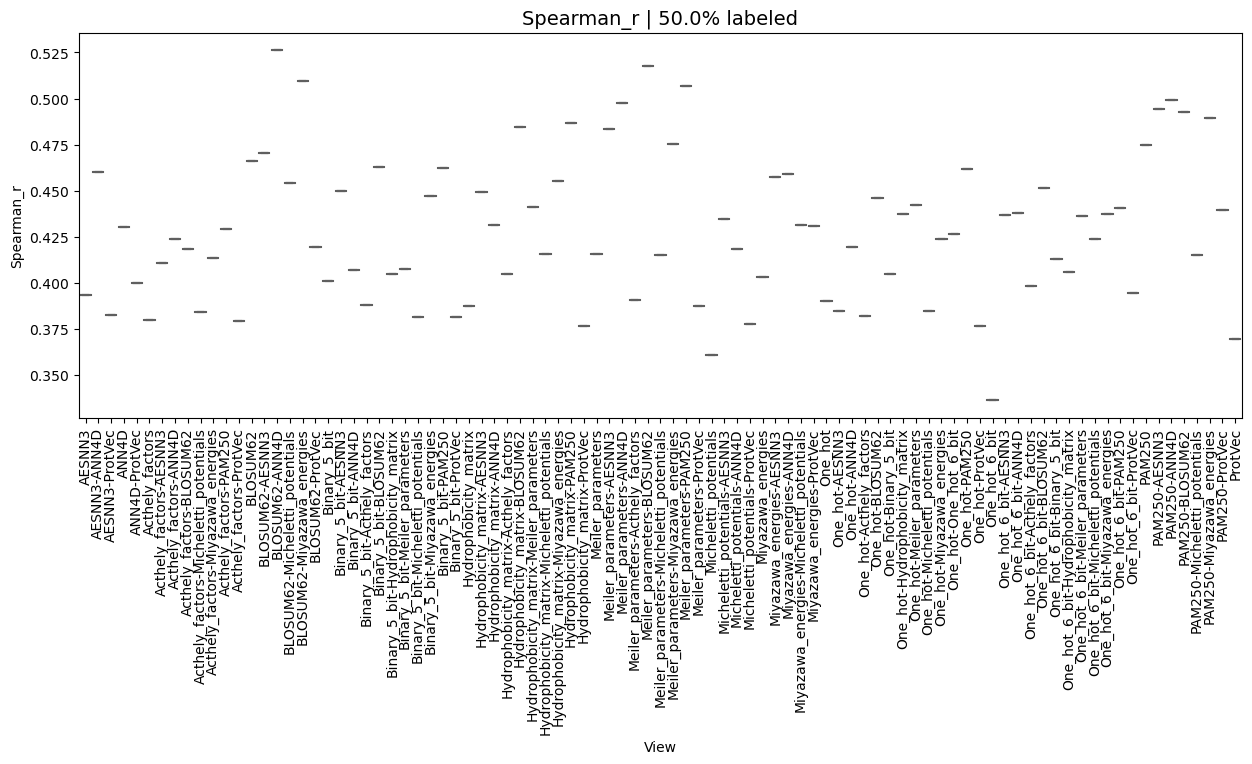

In [8]:
# Draw a boxplot grouped by view
labeled = 0.5
metric = "Spearman_r"

boxplot_df = df.loc[df['Labeled'] == labeled].groupby(['View', 'Labeled']).mean().reset_index()

plt.figure(figsize=(15, 5))

ax = sns.boxplot(x="View", y=metric, data=boxplot_df, palette="Set3")

# Turn x axis labels 90 degrees
for item in ax.get_xticklabels():
    item.set_rotation(90)


#Plot
plt.title(f'{metric} | {labeled*100}% labeled', fontsize=14)
plt.show()

# Ranking of encoding couples for each labeled percentage

In [9]:
metric = "Spearman_r"   # "MSE", "Spearman_r" or "Weighted_tau"
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    for labeled in labeled_sizes:
        # Rank df by AUC mean grouped by view and labeled
        display(df.loc[(df["Labeled"] == labeled)].groupby(['View', 'Labeled']).mean().sort_values(by=metric, ascending=False).head(10))

,,MSE,Spearman_r,Weighted_tau
View,Labeled,,,
BLOSUM62-ANN4D,0.5,0.438903,0.526264,0.483823
Meiler_parameters-BLOSUM62,0.5,0.475168,0.517838,0.479072
BLOSUM62-Miyazawa_energies,0.5,0.422252,0.509432,0.434489
Meiler_parameters-PAM250,0.5,0.452414,0.506770,0.450959
PAM250-ANN4D,0.5,0.456772,0.499231,0.417397
Meiler_parameters-ANN4D,0.5,0.474585,0.497747,0.420341
PAM250-AESNN3,0.5,0.436493,0.494436,0.418026
PAM250-BLOSUM62,0.5,0.465335,0.492740,0.465712
PAM250-Miyazawa_energies,0.5,0.445318,0.489541,0.381075


,,MSE,Spearman_r,Weighted_tau
View,Labeled,,,
BLOSUM62-Micheletti_potentials,0.25,0.519073,0.393589,0.255598
Acthely_factors-AESNN3,0.25,0.519968,0.376402,0.381498
BLOSUM62-AESNN3,0.25,0.562660,0.353418,0.286198
Miyazawa_energies-AESNN3,0.25,0.537674,0.350551,0.270316
PAM250-Micheletti_potentials,0.25,0.523951,0.347830,0.363077
Hydrophobicity_matrix-PAM250,0.25,0.544918,0.345991,0.138050
ANN4D-ProtVec,0.25,0.526913,0.334984,0.204028
Acthely_factors-Micheletti_potentials,0.25,0.518112,0.322128,0.270151
Hydrophobicity_matrix-Miyazawa_energies,0.25,0.543549,0.321601,0.142276


,,MSE,Spearman_r,Weighted_tau
View,Labeled,,,
Meiler_parameters-PAM250,0.1,0.644080,0.244567,0.319113
One_hot_6_bit-Acthely_factors,0.1,0.631429,0.231225,0.331125
BLOSUM62-ProtVec,0.1,0.610222,0.227612,0.249490
One_hot-Micheletti_potentials,0.1,0.550056,0.224018,0.307247
Hydrophobicity_matrix-AESNN3,0.1,0.594087,0.222956,0.369023
Miyazawa_energies-AESNN3,0.1,0.499206,0.221094,0.155783
Meiler_parameters-AESNN3,0.1,0.578960,0.220856,0.219860
One_hot-ProtVec,0.1,0.526313,0.220769,0.302575
Hydrophobicity_matrix-Meiler_parameters,0.1,0.573154,0.217608,0.201863


,,MSE,Spearman_r,Weighted_tau
View,Labeled,,,
One_hot_6_bit-Hydrophobicity_matrix,0.01,0.635421,0.157950,0.306399
Binary_5_bit-Miyazawa_energies,0.01,0.626479,0.155897,0.197615
One_hot_6_bit-Micheletti_potentials,0.01,0.602467,0.147009,0.232732
One_hot_6_bit-Meiler_parameters,0.01,0.665742,0.127694,0.242957
One_hot_6_bit-PAM250,0.01,0.577884,0.123075,0.197581
Hydrophobicity_matrix-ANN4D,0.01,0.644614,0.116140,0.077134
Binary_5_bit-BLOSUM62,0.01,0.555064,0.099117,0.232921
Binary_5_bit-PAM250,0.01,0.652677,0.098593,0.179650
One_hot_6_bit-Acthely_factors,0.01,0.691709,0.094938,0.196129
